In [5]:
#https://towardsdatascience.com/using-deep-learning-ai-to-predict-the-stock-market-9399cf15a312
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from datetime import timedelta
import pandas_datareader as web
from sklearn.preprocessing import RobustScaler
plt.style.use("bmh")

# Neural Network library
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed
# Loading in the Data
start = dt.datetime(2000, 1, 1)
end = dt.datetime.now()
#df = web.DataReader("MVIS", 'yahoo', start, end)
#df = pd.read_csv("TSLA.csv")
df = pd.read_csv('sp500_joined_closes_shift_with_volume.csv')

In [6]:
def process_multiple_stock(df):
    df = df.drop(['Date'],axis=1)
    dataset = df.values
    return dataset
#scaled_data = scaled_data[1:]
#print(scaled_data)

In [8]:
#x = process_multiple_stock(df)
df.set_index('Date', inplace=True)
df = df.fillna(0)
df.index = pd.to_datetime(df.index)
#df = df.drop(['Date'],axis=1)

df.rename(columns={'NVDA': 'Close'}, inplace=True)

#print(df.index)
close_scaler = RobustScaler()
close_scaler.fit(df[['Close']])

scaler = RobustScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
print(df.columns)
print(df.head())

KeyError: 'Date'

In [4]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the multivariate time sequence
    """
    
    # Creating a list for both variables
    X, y = [], []
    
    for i in range(len(seq)):
        
        # Finding the end of the current sequence
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        # Breaking out of the loop if we have exceeded the dataset's length
        if out_end > len(seq):
            break
        
        # Splitting the sequences into: x = past prices and indicators, y = prices ahead
        seq_x, seq_y = seq[i:end, :], seq[end:out_end, 0]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)
    
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(16,5))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(16,5))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass
                 
def validater(n_per_in, n_per_out):
    """
    Runs a 'For' loop to iterate through the length of the DF and create predicted values for every stated interval
    Returns a DF containing the predicted values for the model with the corresponding index values based on a business day frequency
    """
    
    # Creating an empty DF to store the predictions
    print(df.index)
    predictions = pd.DataFrame(index=df.index, columns=[df.columns[0]])
   # print(predictions.columns)
    for i in range(n_per_in, len(df)-n_per_in, n_per_out):
        # Creating rolling intervals to predict off of
        x = df[-i - n_per_in:-i]

        # Predicting using rolling intervals
        yhat = model.predict(np.array(x).reshape(1, n_per_in, n_features))
        
        # Transforming values back to their normal prices
        yhat = close_scaler.inverse_transform(yhat)[0]

        # DF to store the values and append later, frequency uses business days
        pred_df = pd.DataFrame(yhat, 
                               index=pd.date_range(start=x.index[-1], 
                                                   periods=len(yhat), 
                                                   freq="B"),
                               columns=[x.columns[0]])
        
        #return pred_df
        # Updating the predictions DF
        #print(pred_df.columns)
        predictions.update(pred_df)
    #print(predictions)
    return predictions


def val_rmse(df1, df2):
    """
    Calculates the root mean square error between the two Dataframes
    """
    df = df1.copy()
    
    # Adding a new column with the closing prices from the second DF
    df['Close2'] = df2.close
    
    # Dropping the NaN values
    df.dropna(inplace=True)
    
    # Adding another column containing the difference between the two DFs' closing prices
    df['diff'] = df.close - df.close2
    
    # Squaring the difference and getting the mean
    rms = (df[['diff']]**2).mean()
    
    # Returning the sqaure root of the root mean square
    return float(np.sqrt(rms))

In [7]:
# How many periods looking back to learn
n_per_in  = 90
# How many periods to predict
n_per_out = 1
# Features 
n_features = df.shape[1]
# Splitting the data into appropriate sequences
X, y = split_sequence(df.values, n_per_in, n_per_out)
print(X.shape)
print(y.shape)

(2540, 90, 505)
(2540, 1)


In [ ]:
## Creating the NN

# Instatiating the model
model = Sequential()

# Activation
activ = "tanh"

# Input layer
model.add(LSTM(90, 
               activation=activ, 
               return_sequences=True,
               input_shape=(n_per_in, n_features)))
#model.add(LSTM(60, activation='relu'))
#model.add(LSTM(30, activation='relu'))

# Hidden layers
layer_maker(n_layers=1, 
            n_nodes=30, 
            activation=activ)
#layer_maker(n_layers=1, 
#            n_nodes=30, 
#            activation=activ)
#layer_maker(n_layers=1, 
#            n_nodes=30, 
#            activation=activ)

# Final Hidden layer
model.add(LSTM(60, activation=activ))




# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

## Fitting and Training
res = model.fit(X, y, epochs=2, batch_size=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 90, 90)            214560    
_________________________________________________________________
lstm_4 (LSTM)                (None, 90, 30)            14520     
_________________________________________________________________
lstm_5 (LSTM)                (None, 60)                21840     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 61        
Total params: 250,981
Trainable params: 250,981
Non-trainable params: 0
_________________________________________________________________
Train on 2540 samples
Epoch 1/2
 185/2540 [=>............................] - ETA: 34:12 - loss: 1.5014 - accuracy: 0.0000e+00

DatetimeIndex(['2009-12-31', '2010-01-04', '2010-01-05', '2010-01-06',
               '2010-01-07', '2010-01-08', '2010-01-11', '2010-01-12',
               '2010-01-13', '2010-01-14',
               ...
               '2020-06-01', '2020-06-02', '2020-06-03', '2020-06-04',
               '2020-06-05', '2020-06-08', '2020-06-09', '2020-06-10',
               '2020-06-11', '2020-06-12'],
              dtype='datetime64[ns]', name='Date', length=2630, freq=None)
                    MMM
Date                   
2020-01-22 -3.88691e+09
2020-01-23 -3.81065e+09
2020-01-24 -3.86642e+09
2020-01-27 -3.86317e+09
2020-01-28 -3.95536e+09
2020-01-29 -3.92097e+09
2020-01-30          NaN
2020-01-31          NaN
2020-02-03          NaN
2020-02-04 -3.68555e+09
2020-02-05  -3.7011e+09
2020-02-06 -3.81999e+09
2020-02-07 -3.77994e+09
2020-02-10  -3.8596e+09
2020-02-11 -3.84546e+09
2020-02-12  -3.8188e+09
2020-02-13 -3.85115e+09
2020-02-14 -3.73904e+09
2020-02-18  -3.8503e+09
2020-02-19 -3.90658e+09
2020-02

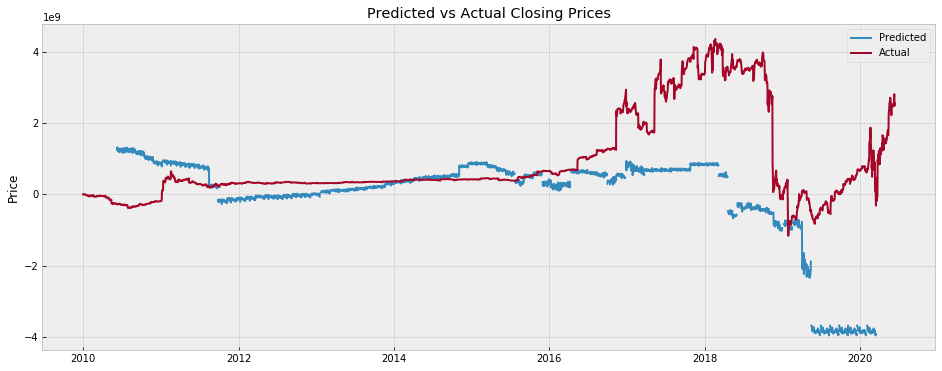

In [11]:
# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]]), 
                      index=df.index, 
                      columns=[df.columns[0]])

# Getting a DF of the predicted values to validate against
predictions = validater(n_per_in, n_per_out)
#print(temp.head(100))
#print(temp.index)
#predictions = pd.DataFrame(index=df.index, columns=[df.columns[0]])
#predictions.update(temp)
print(predictions.tail(100))
# Printing the RMSE
#print("RMSE:", val_rmse(actual, predictions))
    
# Plotting
plt.figure(figsize=(16,6))

# Plotting those predictions
plt.plot(predictions, label='Predicted')

# Plotting the actual values
plt.plot(actual, label='Actual')

plt.title("Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
#plt.xlim('2010-05', '2020-05')
plt.show()

[[-5.62020476  0.55118276 -7.15353883 ...  0.10037579  0.37813745
   2.8890693 ]
 [-5.60767637  0.54861231 -7.12530984 ...  0.11296937  0.33733896
   2.92681701]
 [-5.65806411  0.5007563  -6.48090367 ...  0.09407847  0.29857639
   2.92484249]
 ...
 [-5.58001187  2.41264509 -6.66749162 ... -0.52932135 -1.19209772
   2.36497523]
 [-5.95874444  2.17337287 -7.05322766 ... -0.73587189 -1.42156121
   2.01119294]
 [-5.90980982  2.21973356 -7.04264651 ... -0.67500253 -1.33648597
   2.0893049 ]]
                 MMM       ABT      ABBV      ABMD       ACN      ATVI  \
Date                                                                     
2020-06-08 -5.529674  2.413357 -6.820940 -8.280652 -0.420670  0.020453   
2020-06-09 -5.533196  2.338965 -6.721203 -8.331393 -0.512710  0.037611   
2020-06-10 -5.580012  2.412645 -6.667492 -8.300961 -0.468026  0.073467   
2020-06-11 -5.958744  2.173373 -7.053228 -8.426253 -1.029476  0.030563   
2020-06-12 -5.909810  2.219734 -7.042647 -8.391308 -0.879118  0.

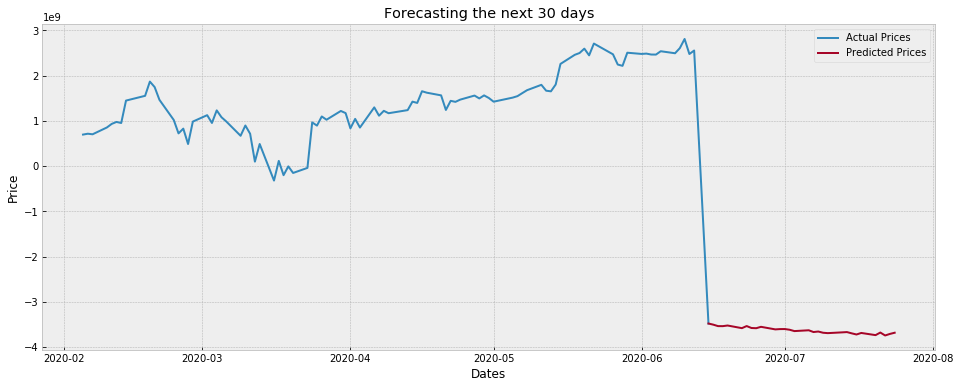

In [8]:
#Predicting off of the most recent days from the original DF
print(np.array(df.tail(n_per_in)))
print(df.tail())
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features))

# Transforming the predicted values back to their original format
yhat = close_scaler.inverse_transform(yhat)[0]

#print(df.index[-1])
# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, 
                     index=pd.date_range(start=df.index[-1]+timedelta(days=1), 
                                         periods=len(yhat), 
                                         freq="B"), 
                     columns=[df.columns[0]])


# Number of periods back to plot the actual values
pers = n_per_in

# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]].tail(pers)), 
                      index=df.Close.tail(pers).index, 
                      columns=[df.columns[0]]).append(preds.head(1))





# Printing the predicted prices
print(preds)

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title("Forecasting the next {} days".format(len(yhat)))
plt.legend()
plt.show()